# Batched Generalized Minimal Residual
In this tutorial we describe the basics of using the batched gmres iterative solver.
At the end you should be able to
1. Use BatchedGeneralizedMinimalResidual to solve batches of linear systems
2. Construct a columnwise linear solver with BatchedGeneralizedMinimalResidual

## What is the Generalized Minimal Residual Method?
The  Generalized Minimal Residual Method (GMRES) is a [Krylov subspace](https://en.wikipedia.org/wiki/Krylov_subspace) method for solving linear systems:
$$
 Ax = b
$$
See the [wikipedia](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method) for more details.

## What is the Batched Generalized Minimal Residual Method?
As the name suggests it solves a whole bunch of independent GMRES problems

## Basic Example
First we must load a few things

In [1]:
using ClimateMachine
using ClimateMachine.SystemSolvers
using LinearAlgebra, Random, Plots

Next we define two linear systems that we would like to solve simultaneously.
The matrix for the first linear system is

In [2]:
A1 = [
    2.0 -1.0 0.0
    -1.0 2.0 -1.0
    0.0 -1.0 2.0
];

And the right hand side is

In [3]:
b1 = ones(typeof(1.0), 3);

The exact solution to the first linear system is

In [4]:
x1_exact = [1.5, 2.0, 1.5];

The matrix for the first linear system is

In [5]:
A2 = [
    2.0 -1.0 0.0
    0.0 2.0 -1.0
    0.0 0.0 2.0
];

And the right hand side is

In [6]:
b2 = ones(typeof(1.0), 3);

The exact solution to second linear system is

In [7]:
x2_exact = [0.875, 0.75, 0.5];

We now define a function that performs the action of each linear operator independently.

In [8]:
function closure_linear_operator(A1, A2)
    function linear_operator!(x, y)
        mul!(view(x, :, 1), A1, view(y, :, 1))
        mul!(view(x, :, 2), A2, view(y, :, 2))
        return nothing
    end
    return linear_operator!
end;

To understand how this works let us construct an instance
of the linear operator and apply it to a vector

In [9]:
linear_operator! = closure_linear_operator(A1, A2);

Let us see what the action of this linear operator is

In [10]:
y1 = ones(typeof(1.0), 3);
y2 = ones(typeof(1.0), 3) * 2.0;
y = [y1 y2];
x = copy(y);
linear_operator!(x, y);
x

3×2 Array{Float64,2}:
 1.0  2.0
 0.0  2.0
 1.0  4.0

We see that the first column is `A1 * [1 1 1]'`
and the second column is `A2 * [2 2 2]'`
that is,

In [11]:
[A1 * y1 A2 * y2]

3×2 Array{Float64,2}:
 1.0  2.0
 0.0  2.0
 1.0  4.0

We are now ready to set up our Batched Generalized Minimal Residual solver
We must now set up the right hand side of the linear system

In [12]:
b = [b1 b2];

as well as the exact solution, (to verify convergence)

In [13]:
x_exact = [x1_exact x2_exact];

!!! warning
    For BatchedGeneralizedMinimalResidual the assumption is that each column of b is independent and corresponds to a batch. This will come back later.

We now use an instance of the solver

In [14]:
linearsolver = BatchedGeneralizedMinimalResidual(b, size(A1, 1), 2);

As well as an initial guess, denoted by the variable x

In [15]:
x1 = ones(typeof(1.0), 3);
x2 = ones(typeof(1.0), 3);
x = [x1 x2];

To solve the linear system, we just need to pass to the linearsolve! function

In [16]:
iters = linearsolve!(linear_operator!, nothing, linearsolver, x, b)

3

which is guaranteed to converge in 3 iterations since `length(b1)=length(b2)=3`
We can now check that the solution that we computed, x

In [17]:
x

3×2 Array{Float64,2}:
 1.5  0.875
 2.0  0.75
 1.5  0.5

has converged to the exact solution

In [18]:
x_exact

3×2 Array{Float64,2}:
 1.5  0.875
 2.0  0.75
 1.5  0.5

Which indeed it has.
## Advanced Example

We now go through a more advanced application of the Batched Generalized Minimal Residual solver
!!! warning
    Iterative methods should be used with preconditioners!
The first thing we do is define a linear operator that mimics
the behavior of a columnwise operator in ClimateMachine

In [19]:
function closure_linear_operator!(A, tup)
    function linear_operator!(y, x)
        alias_x = reshape(x, tup)
        alias_y = reshape(y, tup)
        for i6 in 1:tup[6]
            for i4 in 1:tup[4]
                for i2 in 1:tup[2]
                    for i1 in 1:tup[1]
                        tmp = alias_x[i1, i2, :, i4, :, i6][:]
                        tmp2 = A[i1, i2, i4, i6] * tmp
                        alias_y[i1, i2, :, i4, :, i6] .=
                            reshape(tmp2, (tup[3], tup[5]))
                    end
                end
            end
        end
    end
end;

Next we define the array structure of an MPIStateArray
in its true high dimensional form

In [20]:
tup = (2, 2, 5, 2, 10, 2);

We define our linear operator as a random matrix

In [21]:
Random.seed!(1234);
B = [
    randn(tup[3] * tup[5], tup[3] * tup[5])
    for i1 in 1:tup[1], i2 in 1:tup[2], i4 in 1:tup[4], i6 in 1:tup[6]
];
columnwise_A = [
    B[i1, i2, i4, i6] + 3 * (i1 + i2 + i4 + i6) * I
    for i1 in 1:tup[1], i2 in 1:tup[2], i4 in 1:tup[4], i6 in 1:tup[6]
];

as well as its inverse

In [22]:
columnwise_inv_A = [
    inv(columnwise_A[i1, i2, i4, i6])
    for i1 in 1:tup[1], i2 in 1:tup[2], i4 in 1:tup[4], i6 in 1:tup[6]
];
columnwise_linear_operator! = closure_linear_operator!(columnwise_A, tup);
columnwise_inverse_linear_operator! =
    closure_linear_operator!(columnwise_inv_A, tup);

The structure of an MPIStateArray is related to its true
higher dimensional form as follows:

In [23]:
mpi_tup = (tup[1] * tup[2] * tup[3], tup[4], tup[5] * tup[6]);

We now define the right hand side of our Linear system

In [24]:
b = randn(mpi_tup);

As well as the initial guess

In [25]:
x = copy(b);
x += randn(mpi_tup) * 0.1;

In the previous tutorial we mentioned that it is assumed that
the right hand side is an array whose column vectors all independent linear
systems. But right now the array structure of ``x`` and ``b`` do not follow
this requirement.
To handle this case we must pass in additional arguments that tell the
linear solver how to reconcile these differences.
The first thing that the linear solver must know of is the higher tensor
form of the MPIStateArray, which is just the `tup` from before

In [26]:
reshape_tuple_f = tup;

The second thing it needs to know is which indices correspond to a column
and we want to make sure that these are the first set of indices that appear
in the permutation tuple (which can be thought of as enacting
a Tensor Transpose).

In [27]:
permute_tuple_f = (5, 3, 4, 6, 1, 2);

It has this format since the 3 and 5 index slots
are the ones associated with traversing a column. And the 4 index
slot corresponds to a state.
We also need to tell our solver which kind of Array struct to use

In [28]:
ArrayType = Array;

We are now ready to finally define our linear solver, which uses a number
of keyword arguments

In [29]:
gmres = BatchedGeneralizedMinimalResidual(
    b,
    tup[3] * tup[5] * tup[4],
    tup[1] * tup[2] * tup[6];
    atol = eps(Float64) * 100,
    rtol = eps(Float64) * 100,
    forward_reshape = reshape_tuple_f,
    forward_permute = permute_tuple_f,
);

`m` is the number of gridpoints along a column. As mentioned previously,
this is `tup[3]*tup[5]*tup[4]`. The `n` term corresponds to the batch size
or the number of columns in this case. `atol` and `rtol` are relative and
absolute tolerances

All the hard work is done, now we just call our linear solver

In [30]:
iters = linearsolve!(
    columnwise_linear_operator!,
    nothing,
    gmres,
    x,
    b,
    max_iters = tup[3] * tup[5] * tup[4],
)

52

We see that it converged in less than `tup[3]*tup[5] = 50` iterations.
Let us verify that it is indeed correct by computing the exact answer
numerically and comparing it against the iterative solver.

In [31]:
x_exact = copy(x);
columnwise_inverse_linear_operator!(x_exact, b);

Now we can compare with some norms

In [32]:
norm(x - x_exact) / norm(x_exact)
columnwise_linear_operator!(x_exact, x);
norm(x_exact - b) / norm(b)

1.2827339696812677e-13

Which we see are small, given our choice of `atol` and `rtol`.
The struct also keeps a record of its convergence rate
in the residual member (max over all batched solvers).
The can be visualized via

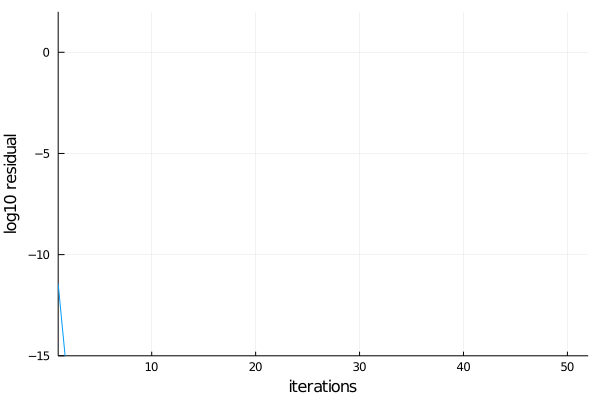

In [33]:
plot(log.(gmres.resnorms[:]) / log(10));
plot!(legend = false, xlims = (1, iters), ylims = (-15, 2));
plot!(ylabel = "log10 residual", xlabel = "iterations")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*